# Analizando comments de tiktok

In [34]:
import os
import re
from dotenv import load_dotenv

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from wordcloud import WordCloud, STOPWORDS

from google import genai

load_dotenv()

True

In [35]:
# Load dataset
csv_path = "data/comments_extracted.csv"
try:
    df = pd.read_csv(csv_path, encoding="utf-8", low_memory=False)
except FileNotFoundError:
    raise FileNotFoundError(f"{csv_path} not found. Please check the path relative to the notebook.")

# Quick inspection
print("Shape:", df.shape)
df = df.drop_duplicates()
df.head()

Shape: (224, 8)


,cid,reply_id,reply_comment_total,create_time,digg_count,text,user.nickname,user.unique_id
0,7563577820010873618,0,0,1761032698,0,"pues... si usas PHP 5.6, sí",frank,frank.begue
1,7566626250224354060,0,0,1761742471,0,Por eso me pasé a WebAssembly. Rust a WASM vue...,El Compa Walter,elcompawalter
2,7565976483208266504,0,0,1761591188,0,PHP será el cobol de plataformas web,Sam Montano,hiro_nakamura1
3,7566340827258782472,0,0,1761676015,1,"sigue siendo como 70 porciento de internet, de...",Snow Flame,snow_flam3
4,7566633731756589836,0,0,1761744219,0,Y aún así más vigente que nunca 🙃,atisdumuzi,atisdumuzi


In [39]:
# Sort by digg_count in descending order and take top 5
top = df.nlargest(10, 'digg_count')[['user.nickname', 'user.unique_id', 'text', 'digg_count']]

# Display results
print("\nTop 10 Comments by Likes (digg_count):")
for _, row in top.iterrows():
    display(Markdown(
f"""- Comment: {row['text']}
- User: {row['user.nickname']} (ID: {row['user.unique_id']})
- Likes: {row['digg_count']}"""
    ))


Top 10 Comments by Likes (digg_count):


- Comment: agarra algún framework de js, esos duran 15 días
- User: shidoDrk (ID: shidodrk)
- Likes: 94

- Comment: WordPress usa php, Moodle usa php, no van a morir 😅😅
- User: Phillip Troy (ID: philliptroy436)
- Likes: 68

- Comment: Lo llevan diciendo desde que tengo memoria, y aún así me da de comer hoy en día, gracias por todo PHP y Laravel 🙏
- User: CynicalCake19 (ID: cynicalcake19)
- Likes: 54

- Comment: PHP siempre dicen que va a morir y no lo eh visto
- User: coverby196 (ID: coverby196)
- Likes: 23

- Comment: si dices eso es porque no sabes su potencial
- User: Eder Ramos (ID: ederramos81)
- Likes: 18

- Comment: 😂😂😂 Php lleva muerto desde que lo empecé a aprender con WordPress mira que bien ya 10 años viviendo y bastante bien de pura tecnología muerta
- User: Jose Ramon6145 (ID: joseramon6145)
- Likes: 7

- Comment: Llevan años diciendo eso sobre PHP 🤣
- User: Akzel Bastien (ID: akzelbastien)
- Likes: 6

- Comment: Uy! Que miedo ultimo release 20 de NOVIEMBRE de 2025 version 8.5 🤣🤣🤣 … buen momento para aprender… ruby ? 🤣🤣🤣… vercel caido? Angular con dos versiones incompatibles y antiguas? 🤣🤣🤣
- User: dimandersen (ID: dimandersen)
- Likes: 4

- Comment: igual es demasiado usada es como cobol, algo dinosaurio y muchos bancos lo usan
- User: Zeus890 (ID: zeus89015)
- Likes: 3

- Comment: en la empresa donde trabajaba había unos proyectos en php 7 y cuando corrieron a la única persona que le sabías, ardió Troya
- User: gabrielpech693 (ID: gabrielpech693)
- Likes: 3

In [40]:
comments_with_likes = df[df['digg_count'] > 0][['user.nickname', 'user.unique_id', 'text', 'digg_count']]

comments_with_likes_sorted = comments_with_likes.sort_values(by='digg_count', ascending=False)
comments_with_likes_sorted.reset_index(drop=True, inplace=True)
comments_with_likes_sorted

,user.nickname,user.unique_id,text,digg_count
0,shidoDrk,shidodrk,"agarra algún framework de js, esos duran 15 días",94
1,Phillip Troy,philliptroy436,"WordPress usa php, Moodle usa php, no van a mo...",68
2,CynicalCake19,cynicalcake19,"Lo llevan diciendo desde que tengo memoria, y ...",54
3,coverby196,coverby196,PHP siempre dicen que va a morir y no lo eh visto,23
4,Eder Ramos,ederramos81,si dices eso es porque no sabes su potencial,18
5,Jose Ramon6145,joseramon6145,😂😂😂 Php lleva muerto desde que lo empecé a apr...,7
6,Akzel Bastien,akzelbastien,Llevan años diciendo eso sobre PHP 🤣,6
7,dimandersen,dimandersen,Uy! Que miedo ultimo release 20 de NOVIEMBRE d...,4
8,2deAlpastor,2dalpastor,PHP nos va a enterrar a todos,3
9,Renmy⫍ ⃢👁ܫ👁⃢ ⫎,kigmrom,comunidad Laravel: php no vas a morir porque y...,3


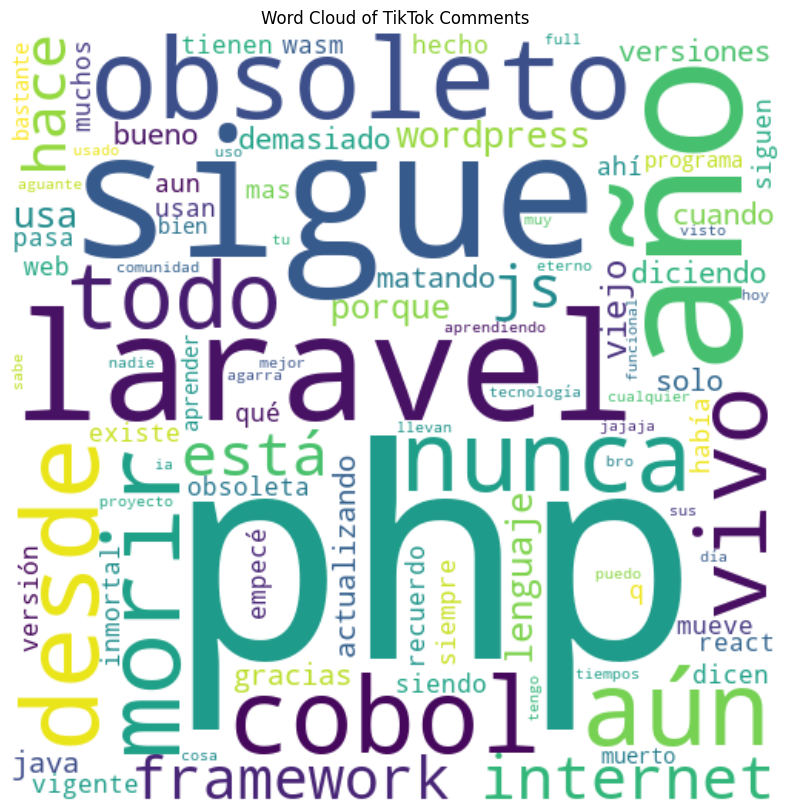

In [41]:
# Clean and concatenate all comments
text = ' '.join(df['text'].astype(str))
text = re.sub(r'[^\w\s]', '', text.lower())

# Remove specified Spanish stop words from the cleaned text
stopwords = set(STOPWORDS)
stopwords.update(map(str.lower, {
    "en", "yo", "los", "sí", "si", "es", "de", "el", "más", "ni", "da", "un",
    "que", "por", "con", "ya", "una", "eso", "lo", "que", "uy", "te", "se",
    "unos", "así", "le", "ser", "para", "y", "va", "algún", "esos", "mi",
    "como", "va", "del", "pero", "la", "etc", "su", "al"
}))
#stopwords.add("de")

# Create and generate a word cloud image
wordcloud = WordCloud(width=500, height=500, 
                     stopwords=stopwords,
                     background_color='white',
                     colormap='viridis',
                     min_font_size=10).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of TikTok Comments')
plt.show()

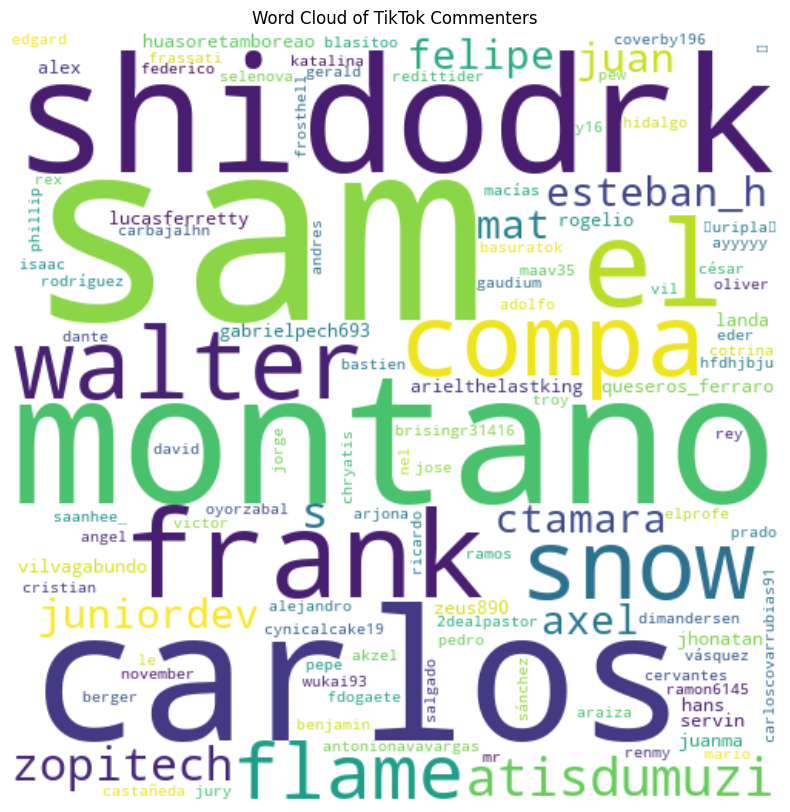

In [42]:
# Clean and concatenate all comments
names = ' '.join(df['user.nickname'].astype(str))
names = re.sub(r'[^\w\s]', '', names.lower())

# Remove specified Spanish stop words from the cleaned text
stopwords = set(STOPWORDS)

# Create and generate a word cloud image
wordcloud = WordCloud(width=500, height=500, 
                     stopwords=stopwords,
                     background_color='white',
                     colormap='viridis',
                     min_font_size=10).generate(names)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of TikTok Commenters')
plt.show()

In [43]:
client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
response = client.models.generate_content(
    model="gemini-2.5-flash-lite",
    contents=f"Resume en 2 puntos clave los siguientes comentarios de TikTok en español:\n\n{text}"
)

In [44]:
display(Markdown(response.text))

Aquí tienes el resumen en 2 puntos clave de los comentarios de TikTok:

1.  **PHP está lejos de estar obsoleto y sigue siendo muy relevante:** A pesar de las predicciones de su muerte que llevan décadas, PHP se mantiene vigente gracias a su amplio uso (especialmente con WordPress y Laravel), actualizaciones constantes (con versiones recientes como PHP 8.2 y Laravel 12), y la demanda laboral persistente.

2.  **Comparación y Resiliencia:** Se compara a PHP con lenguajes como COBOL o Java, destacando su longevidad y adaptación a pesar de ser considerado "viejo". La fortaleza del ecosistema PHP, especialmente a través de frameworks como Laravel, asegura su continua utilidad y capacidad para generar ingresos y oportunidades profesionales.